In [1]:
from randomDistricts import Hierarchy_2D
from gerrychain import (Graph, Partition, MarkovChain, tree,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from treelib import Node, Tree
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
import pandas as pd
import seaborn as sns

In [2]:
# h = Hierarchy_2D("/Users/smaug/Documents/MGGG/data/dallas_county_blocks/dallas_county_blocks10.shp", 
#                  "geoid", "TOTPOP10", ["TOTPOP10", "VAP10"], [3, 1, 6, 3, 2])

with open("data/dallas_hierarcy.p", "rb") as fout:
    h = pickle.load(fout)

In [200]:
d = np.load("test_dist.npy", allow_pickle=True)[0]

In [3]:
pop_col="TOTPOP10"

In [5]:
tracts = h.gdf[["TOTPOP10", "VAP10", "tract", "geometry"]].dissolve(by="tract", aggfunc="sum")

In [6]:
tracts.reset_index(inplace=True)

In [7]:
for pref in ['019','018', '017', '016', '012']:
    print(pref, tracts[tracts.tract.apply(lambda x: x.startswith(pref))].TOTPOP10.sum())

019 225142
018 240506
017 184747
016 319180
012 102399


In [8]:
184747 + 319180 + 102399

606326

In [9]:
606326 / 592034.75

1.024139208044798

In [10]:
tracts["dict"] = tracts.tract.apply(lambda x: x.startswith('017') or x.startswith('012')
                                              or x.startswith('016'))

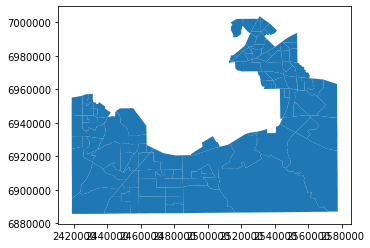

In [11]:
tracts[tracts.tract.apply(lambda x: x.startswith('017') or x.startswith('012')
                                    or x.startswith('016'))].plot()
# TOTPOP10.sum()

In [12]:
tract_list = tracts[tracts.tract.apply(lambda x: x.startswith('017') or x.startswith('012')
                                    or x.startswith('016'))].tract.values

p_packed = Partition(h.graph, {n: h.graph.nodes[n]["tract"] in tract_list for n in h.graph.nodes},
         updaters={"cut_edges": cut_edges, "population": Tally(pop_col)})

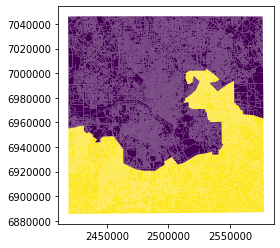

In [13]:
p_packed.plot()

In [14]:
p_packed["population"]

{True: 606326, False: 1761813}

In [15]:
d_packed = {h.graph.nodes[n]["geoid"]: h.graph.nodes[n]["tract"] in tract_list for n in h.graph.nodes}

In [16]:
print(h.assign_district_tree_varriance(d_packed))

print("equal\t", h.assign_district_tree_variance(d_packed, eps=1, eps_splits=[0.2,0.2,0.2,0.2,0.2]))
print("bottom\t", h.assign_district_tree_variance(d_packed, eps=1, eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2]))
print("mid\t", h.assign_district_tree_variance(d_packed, eps=1, eps_splits=[1/12, 1/6, 1/2, 1/6, 1/12]))
print("top\t", h.assign_district_tree_variance(d_packed, eps=1, eps_splits=[1/2, 1/4, 1/12, 1/12, 1/12]))

85.95085066162446
equal	 4297.542533081223
bottom	 24753.84499054785
mid	 6188.461247636962
top	 2750.427221171983


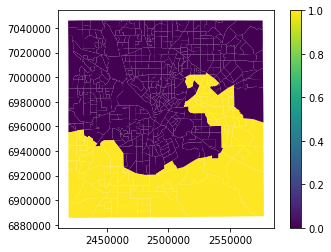

In [17]:
tracts.plot(column="dict", legend=True)

## Sample Districts for Dallas

In [18]:
def sample_districts(sizes, init_parts, h, geoid, tot_pop, pop_col="TOTPOP10", tot_steps=1000):
    districts = {size:{} for size in sizes}
    
    for size, init_part in zip(sizes, init_parts):
        print(size)
        ## set up chain
        ideal_pop = tot_pop/size
        proposal = partial(recom,
                   pop_col=pop_col,
                   pop_target=ideal_pop,
                   epsilon=0.05,
                   node_repeats=1)
        pop_constraint = constraints.within_percent_of_ideal_population(init_part, 0.05)
        
        chain = MarkovChain(
            proposal=proposal,
            constraints=[pop_constraint],
            accept=accept.always_accept,
            initial_state=init_part,
            total_steps=tot_steps
        )
        
        ## run chain and gather districts
        ds = set()
        for p in chain:
            print("*", end="", flush=True)
            ds |= set(p.parts.values())
        print()

        ## Covert to parts
        d_parts = []
        d_dicts = []
        for d in ds:
            d_parts.append(Partition(h.graph, {n: int(n in d) for n in h.graph.nodes},
                           updaters={"cut_edges": cut_edges, "population": Tally(pop_col)}))
            d_dicts.append({h.graph.nodes[n][geoid]: int(n in d) for n in h.graph.nodes})
        
        districts[size]["dicts"] = d_dicts
        districts[size]["parts"] = d_parts
    
    return districts

In [19]:
def variance_size_ratio(districts, h):
    variances = []
    sizes = []
#     ratios = []
    for k,v in districts.items():
        vs = [h.assign_district_tree_variance(d) for d in v["dicts"]]
        variances.extend(vs)
#         ratios.extend(vs / min(vs))
        sizes.extend([k for d in v["dicts"]])
    return variances, sizes, #ratios

In [20]:
cdict = tree.recursive_tree_part(h.graph, range(4), h.gdf.TOTPOP10.sum() / 4, pop_col, 0.02, node_repeats=1)

In [21]:
init_part = Partition(h.graph, cdict, 
                      updaters={"cut_edges": cut_edges, "population": Tally(pop_col, alias="population")})

In [70]:
d = sample_districts([4], [init_part], h, "geoid", h.gdf.TOTPOP10.sum(), tot_steps=100, pop_col=pop_col)

4
****************************************************************************************************


In [110]:
with open("dallas_district_sample_202.p", "wb") as fin:
    pickle.dump(districts, fin)

In [71]:
[len(d[s]["parts"]) for s in [4]]

[202]

In [72]:
districts = d[4]["dicts"] + [d_packed]

In [73]:
data = pd.DataFrame()

for eps in [0.25, 0.5, 1, 2]:
    print(eps)
    vs_eq = np.array([h.assign_district_tree_variance(dist,eps=eps, 
                                          eps_splits=[0.2,0.2,0.2,0.2,0.2]) for dist in districts])
    vs_tp = np.array([h.assign_district_tree_variance(dist,eps=eps, 
                                              eps_splits=[1/2, 1/4, 1/12, 1/12, 1/12]) for dist in districts])
    vs_md = np.array([h.assign_district_tree_variance(dist,eps=eps, 
                                              eps_splits=[1/12, 1/6, 1/2, 1/6, 1/12]) for dist in districts])
    vs_bt = np.array([h.assign_district_tree_variance(dist,eps=eps, 
                                              eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2]) for dist in districts])
    
    rs_eq = vs_eq / h.assign_district_tree_variance(d_packed, eps=eps, eps_splits=[0.2,0.2,0.2,0.2,0.2])
    rs_tp = vs_tp / h.assign_district_tree_variance(d_packed, eps=eps, eps_splits=[1/2, 1/4, 1/12, 1/12, 1/12])
    rs_md = vs_md / h.assign_district_tree_variance(d_packed, eps=eps, eps_splits=[1/12, 1/6, 1/2, 1/6, 1/12])
    rs_bt = vs_bt / h.assign_district_tree_variance(d_packed, eps=eps, eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2])
    
    df = pd.DataFrame({"ratio": rs_eq, "var": vs_eq, 
                   "type": "eq"}).append(pd.DataFrame({"ratio": rs_tp, 
                   "var": vs_tp, "type": "tp"})).append(pd.DataFrame({"ratio": rs_md, 
                   "var": vs_md, "type": "md"})).append(pd.DataFrame({"ratio": rs_bt, 
                   "var": vs_bt, "type": "bt"})).assign(eps=eps) 
    data = data.append(df)

0.25
0.5
1
2


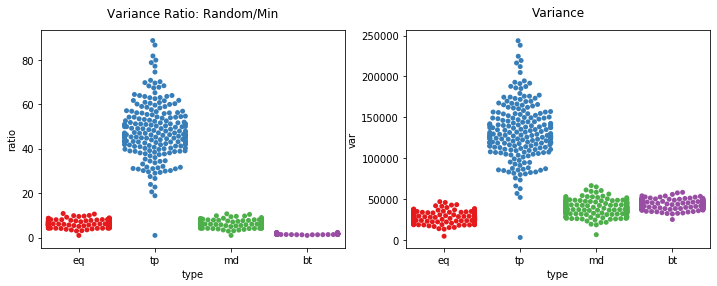

In [106]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

for i, e in enumerate([1]):#[0.25, 0.5, 1, 2]):
    sns.swarmplot(data=data.query("eps == @e"), x="type", y="ratio", palette="Set1", ax=axs[0])
    sns.swarmplot(data=data.query("eps == @e"), x="type", y="var", palette="Set1", ax=axs[1])

pad = 10
# for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(s) for s in [0.25, 0.5, 1, 2]]):
#         ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                     xycoords=ax.yaxis.label, textcoords='offset points',
#                     size='large', ha='right', va='center')
        
for ax, col in zip(axs, ["Variance Ratio: Random/Min", "Variance"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

plt.show()

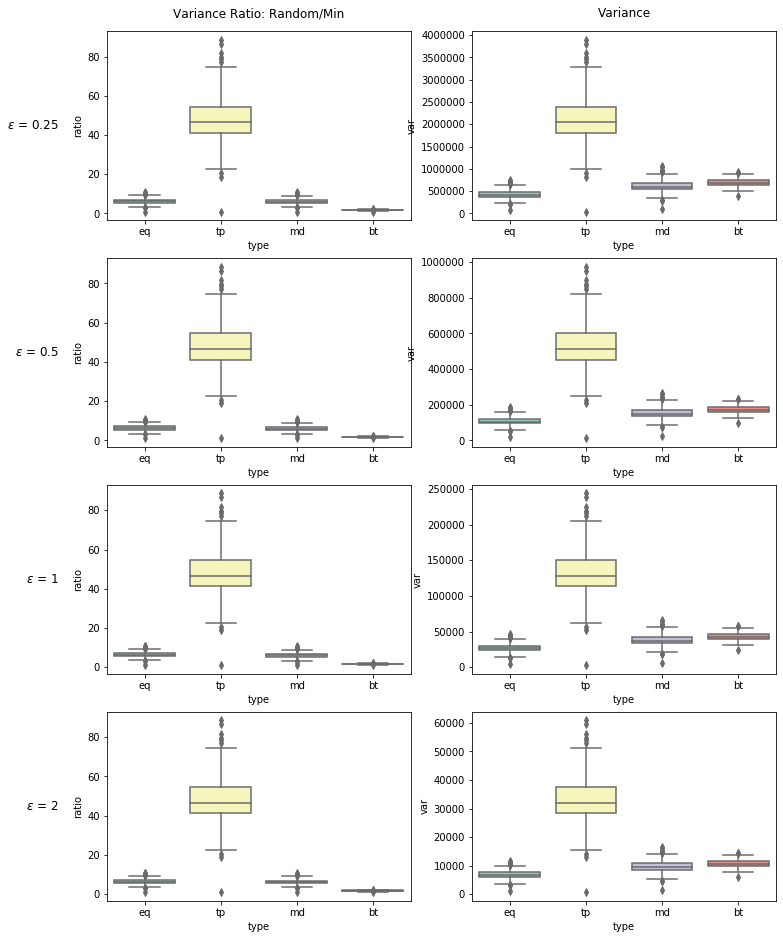

In [78]:
fig, axs = plt.subplots(4,2, figsize=(12,16))

for i, e in enumerate([0.25, 0.5, 1, 2]):
    sns.boxplot(data=data.query("eps == @e"), x="type", y="ratio", palette="Set3", ax=axs[i,0])
    sns.boxplot(data=data.query("eps == @e"), x="type", y="var", palette="Set3", ax=axs[i,1])

pad = 10
for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(s) for s in [0.25, 0.5, 1, 2]]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
        
for ax, col in zip(axs[0], ["Variance Ratio: Random/Min", "Variance"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

plt.show()

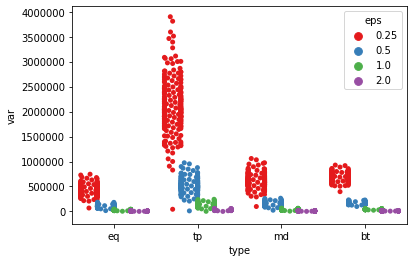

In [111]:
sns.swarmplot(data=data, x="type", y="var", palette="Set1", hue="eps", dodge=True)

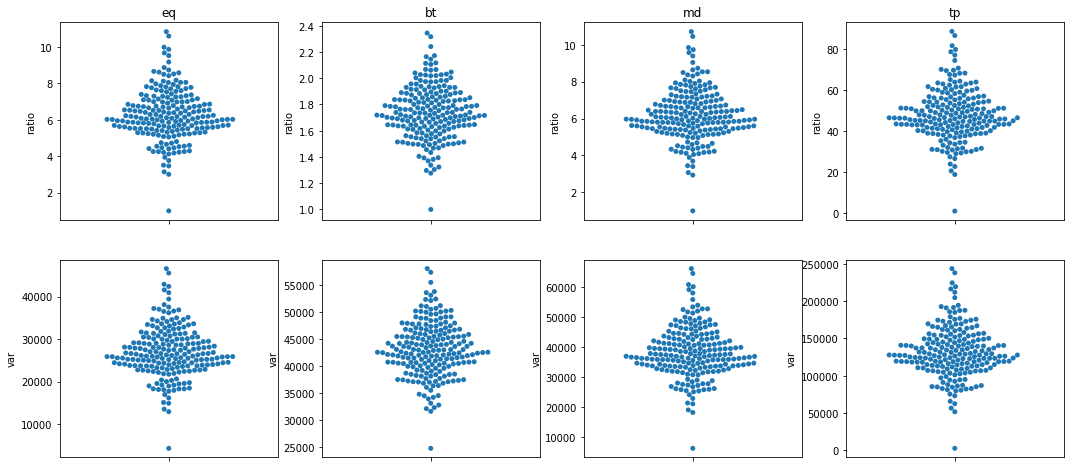

In [102]:
fig, axs = plt.subplots(2,4, figsize=(18,8))

for i,t in enumerate(["eq", "bt", "md", "tp"]):
    axs[0,i].set_title(t)
    sns.swarmplot(data=data.query("type==@t & eps==1"), y="ratio", ax=axs[0, i])
    sns.swarmplot(data=data.query("type==@t & eps==1"), y="var", ax=axs[1, i])
    
plt.show()

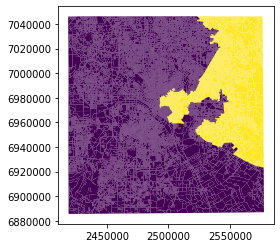

In [118]:
d[4]["parts"][23].plot()

In [124]:
h.assign_district_tree_variance(d[4]["dicts"][23], eps=1, eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2])

42182.253118970315

In [125]:
h.assign_district_tree_variance(d_packed, eps=1, eps_splits=[1/12, 1/12, 1/12, 1/4, 1/2])

24753.84499054785

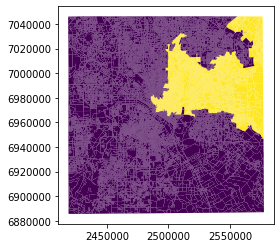

In [114]:
d[4]["parts"][190].plot()

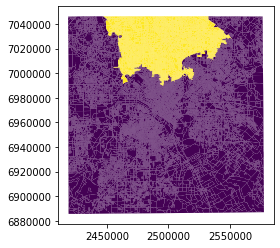

In [113]:
d[4]["parts"][100].plot()

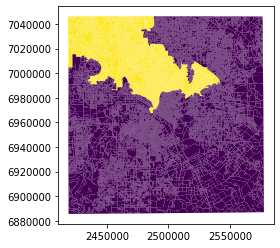

In [112]:
d[4]["parts"][10].plot()

In [ ]:
592034.75

In [238]:
constraints.within_percent_of_ideal_population(init_part, 0.05)(init_part)

True

In [137]:
np.random.randint(0, 203, size=3)

array([92, 89, 50])

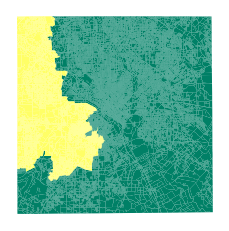

In [161]:
d[4]["parts"][76].plot(cmap="summer")
plt.axis('off')
plt.savefig("plots/random_dccc_dist_1.png", dpi=200, bbox_inches="tight")

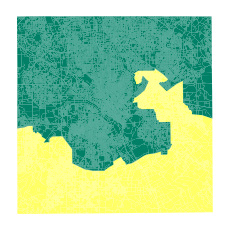

In [165]:
p_packed.plot(cmap="summer")
plt.axis('off')
plt.savefig("plots/random_dccc_packed_tract.png", dpi=200, bbox_inches="tight")

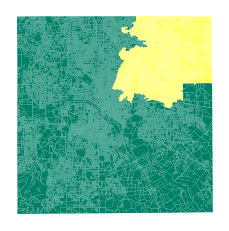

In [162]:
d[4]["parts"][109].plot(cmap="summer")
plt.axis('off')
plt.savefig("plots/random_dccc_dist_2.png", dpi=200, bbox_inches="tight")

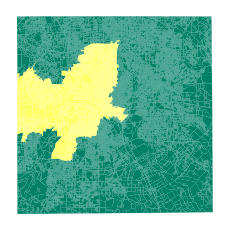

In [163]:
d[4]["parts"][90].plot(cmap="summer")
plt.axis('off')
plt.savefig("plots/random_dccc_dist_3.png", dpi=200, bbox_inches="tight")

In [166]:
districts

[{'481130124005010': 0,
  '481130182062004': 0,
  '481130182061004': 0,
  '481130182063002': 0,
  '481130184021002': 0,
  '481130182064004': 0,
  '481130182051010': 0,
  '481130181103026': 0,
  '481130182063012': 0,
  '481130181103032': 0,
  '481130181201000': 0,
  '481130193021013': 0,
  '481130181232015': 0,
  '481130010022013': 0,
  '481130010022001': 0,
  '481130010022006': 0,
  '481130010022007': 0,
  '481130010022017': 0,
  '481130011012018': 0,
  '481130011011019': 0,
  '481130015041002': 0,
  '481130015042003': 0,
  '481130015032008': 0,
  '481130015043007': 0,
  '481130015044004': 0,
  '481130137111007': 0,
  '481130139012001': 0,
  '481130137143000': 0,
  '481130139012004': 0,
  '481130139021015': 0,
  '481130139013004': 0,
  '481130139013018': 0,
  '481130139021009': 0,
  '481130140012000': 0,
  '481130137122011': 0,
  '481130139023005': 0,
  '481130139023009': 0,
  '481130137121014': 0,
  '481130137122013': 0,
  '481130100002219': 0,
  '481130100002250': 0,
  '4811301000023

In [3]:
with open("data/dallas_district_sample_202.p", "rb") as fin:
    districts = pickle.load(fin)

In [4]:
frag_score = [h.assign_district_tree_variance(dist,eps=1, eps_splits=[np.sqrt(2)]*5) for dist in districts]

In [8]:
[np.sqrt(2)]*5

[1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951]

In [6]:
np.mean(frag_score)

540.7022458177332

In [5]:
frag_score

[448.3745056652976,
 480.56229422215347,
 737.996573276888,
 509.70355603147163,
 582.9572151128635,
 531.6141929040044,
 594.7027184677052,
 501.0496934675967,
 653.5411641780958,
 405.8388831882905,
 662.6627804823312,
 464.9800460769152,
 510.18729777275655,
 579.4489553125927,
 561.3925094358374,
 485.79941990755214,
 559.8915281806137,
 323.64031290732567,
 532.4633866502288,
 270.403654124164,
 633.7597167662541,
 490.9936902262966,
 389.514772534079,
 576.539672881403,
 384.37281917251016,
 556.65914832699,
 453.7632694121291,
 457.9996469042087,
 703.0847134327455,
 647.7590987553826,
 583.0897813649153,
 488.9223369867087,
 489.44473452564887,
 484.20861354009685,
 627.4516258306495,
 488.9767931763623,
 516.2644046443302,
 589.4009314957035,
 450.8486736239893,
 638.2338733022448,
 435.004452101505,
 751.1499347837765,
 515.9313853626405,
 457.3798922939802,
 525.839320960803,
 490.60220757489293,
 692.9794403991134,
 602.5020221916969,
 529.2203225170165,
 932.4202920440307,